In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)

test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)


In [9]:
#dataset dimensions
print(train_set.data.size())
print(train_set.targets.size())
print(test_set.data.size())
print(test_set.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


In [10]:
class_names = datasets.FashionMNIST.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [11]:
# classes distribution
classes = train_set.targets
class_count = torch.zeros(len(class_names))
for c in classes:
    class_count[c] += 1
print(class_count)


tensor([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.])


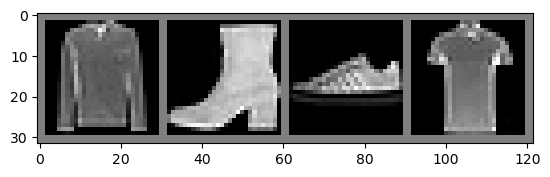

Pullover
Ankle boot
Sneaker
T-shirt/top


In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))
class_names = train_set.classes
for label in labels:
    print(class_names[label])


In [13]:
# Define the network

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = CustomCNN()


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

In [10]:
for epoch in range(20):  # Epoche di addestramento
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Stampa ogni 100 mini-batch
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Valutazione sul set di validazione
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on validation set: %d %%' % (100 * correct / total))

print('Addestramento completato')

[1,   100] loss: 2.303
[1,   200] loss: 2.292
[1,   300] loss: 2.278
[1,   400] loss: 2.245
[1,   500] loss: 2.126
[1,   600] loss: 1.679
[1,   700] loss: 1.194
Accuracy on validation set: 64 %
[2,   100] loss: 0.896
[2,   200] loss: 0.839
[2,   300] loss: 0.812
[2,   400] loss: 0.763
[2,   500] loss: 0.737
[2,   600] loss: 0.717
[2,   700] loss: 0.680
Accuracy on validation set: 74 %
[3,   100] loss: 0.696
[3,   200] loss: 0.665
[3,   300] loss: 0.645
[3,   400] loss: 0.649
[3,   500] loss: 0.643
[3,   600] loss: 0.647
[3,   700] loss: 0.607
Accuracy on validation set: 77 %
[4,   100] loss: 0.592
[4,   200] loss: 0.597
[4,   300] loss: 0.583
[4,   400] loss: 0.578
[4,   500] loss: 0.582
[4,   600] loss: 0.570
[4,   700] loss: 0.562
Accuracy on validation set: 77 %
[5,   100] loss: 0.545
[5,   200] loss: 0.559
[5,   300] loss: 0.519
[5,   400] loss: 0.517
[5,   500] loss: 0.530
[5,   600] loss: 0.548
[5,   700] loss: 0.523
Accuracy on validation set: 80 %
[6,   100] loss: 0.517
[6,   2

In [11]:
# test on test set
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test set: %d %%' % (100 * correct / total))

Accuracy on test set: 87 %


In [26]:
#more complex custom cnn
class CustomNetComplex(nn.Module):
    def __init__(self):
        super(CustomNetComplex, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)  # L'output del secondo max pooling sarà di dimensioni 7x7
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(-1, 256 * 7 * 7)  # Appiattimento prima dei layer fully connected
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_complex = CustomNetComplex()

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_complex.parameters(), lr=0.001, momentum=0.9)

NameError: name 'net_complex' is not defined

In [28]:
for epoch in range(20):  
    net_complex.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_complex(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Stampa ogni 100 mini-batch
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Valutazione sul set di validazione
    net_complex.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = net_complex(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on validation set: %d %%' % (100 * correct / total))

print('Training completed')

[1,   100] loss: 2.302
[1,   200] loss: 2.298
[1,   300] loss: 2.290
[1,   400] loss: 2.266
[1,   500] loss: 1.930
[1,   600] loss: 0.980
[1,   700] loss: 0.804
Accuracy on validation set: 73 %
[2,   100] loss: 0.702
[2,   200] loss: 0.684
[2,   300] loss: 0.671
[2,   400] loss: 0.645
[2,   500] loss: 0.614
[2,   600] loss: 0.628
[2,   700] loss: 0.595
Accuracy on validation set: 77 %
[3,   100] loss: 0.581
[3,   200] loss: 0.580
[3,   300] loss: 0.550
[3,   400] loss: 0.525
[3,   500] loss: 0.546
[3,   600] loss: 0.534
[3,   700] loss: 0.514
Accuracy on validation set: 81 %
[4,   100] loss: 0.507
[4,   200] loss: 0.514
[4,   300] loss: 0.479
[4,   400] loss: 0.472
[4,   500] loss: 0.488
[4,   600] loss: 0.483
[4,   700] loss: 0.458
Accuracy on validation set: 83 %
[5,   100] loss: 0.441
[5,   200] loss: 0.443
[5,   300] loss: 0.457
[5,   400] loss: 0.442
[5,   500] loss: 0.451
[5,   600] loss: 0.418
[5,   700] loss: 0.434
Accuracy on validation set: 83 %
[6,   100] loss: 0.430
[6,   2

In [29]:
net_complex.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net_complex(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test set: %d %%' % (100 * correct / total))

Accuracy on test set: 89 %


In [15]:
class CustomCNNComplex(nn.Module):
    def __init__(self):
        super(CustomCNNComplex, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.5)  # Aggiunta di dropout con probabilità 0.5

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(-1, 256 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  
        x = self.fc3(x)
        return x

net_complex2 = CustomCNNComplex()

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_complex2.parameters(), lr=0.001)

In [23]:
for epoch in range(20):  
    net_complex2.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_complex2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Stampa ogni 100 mini-batch
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Valutazione sul set di validazione
    net_complex2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = net_complex2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy on validation set: {:.2f}%'.format(accuracy))

print('Training completed')

[1,   100] loss: 1.069
[1,   200] loss: 0.587
[1,   300] loss: 0.495
[1,   400] loss: 0.426
[1,   500] loss: 0.398
[1,   600] loss: 0.379
[1,   700] loss: 0.355
Accuracy on validation set: 89.97%
[2,   100] loss: 0.320
[2,   200] loss: 0.317
[2,   300] loss: 0.303
[2,   400] loss: 0.311
[2,   500] loss: 0.303
[2,   600] loss: 0.270
[2,   700] loss: 0.274
Accuracy on validation set: 91.05%
[3,   100] loss: 0.260
[3,   200] loss: 0.241
[3,   300] loss: 0.245
[3,   400] loss: 0.241
[3,   500] loss: 0.256
[3,   600] loss: 0.233
[3,   700] loss: 0.241
Accuracy on validation set: 91.62%
[4,   100] loss: 0.193
[4,   200] loss: 0.209
[4,   300] loss: 0.216
[4,   400] loss: 0.218
[4,   500] loss: 0.215
[4,   600] loss: 0.224
[4,   700] loss: 0.201
Accuracy on validation set: 92.39%
[5,   100] loss: 0.192
[5,   200] loss: 0.178
[5,   300] loss: 0.197
[5,   400] loss: 0.173
[5,   500] loss: 0.197
[5,   600] loss: 0.194
[5,   700] loss: 0.188
Accuracy on validation set: 92.40%
[6,   100] loss: 0.1

In [26]:
net_complex2.eval()
true_labels = []
pred_labels = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net_complex2(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        pred_labels.extend(predicted.numpy())

# Calcola l'accuratezza utilizzando sklearn
accuracy = accuracy_score(true_labels, pred_labels) * 100
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 92.68%
